# Cleaning Up Data - Tracks

In [1]:
import numpy as np
import pandas as pd
import ast

rootpath = '..'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
filepath=f'{rootpath}/data/raw/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [3]:
# only retain required columns
columns = [('album','date_released'), ('album', 'title'), ('album', 'id'),
                ('artist', 'id'), ('artist', 'name'),  
                 ('track', 'genre_top'), ('track', 'genres_all'),
                 ('track', 'title'), ('track', 'duration')]
tracks = tracks[columns]

# remove multindexing
tracks.columns = tracks.columns.droplevel()
tracks.columns = ['year_released', 'album', 'album_id', 'artist_id', 'artist', 'genres_top', 'genres_all', 'track', 'duration']

In [4]:
# remove rows without genre information
tracks = tracks[~(tracks['genres_all'].isnull())]

# fill blank genres_all with []
tracks['genres_all'].fillna('[]', inplace=True)
# fill blank genres_top with 'UNKNOWN'
tracks['genres_top'].fillna('UNKNOWN', inplace=True)

# fix data types
# only retain year for year_released
tracks['year_released'] = [time.year for time in pd.to_datetime(tracks['year_released'], errors='coerce')]
# categorical data
tracks['genres_top'] = tracks['genres_top'].astype('category')
# numeric data
tracks['duration'] = pd.to_numeric(tracks['duration'], errors='coerce')
tracks['duration'].fillna(0, inplace=True)
# list data
tracks = tracks[~(tracks['genres_all']=='[]')] # remove blanks
tracks['genres_all'] = tracks['genres_all'].map(ast.literal_eval)

# remove invalid track ids, set as index
tracks.reset_index(inplace=True)
tracks = tracks[~tracks.track_id.isna()]
tracks.set_index('track_id', inplace=True)
tracks.index = tracks.index.astype(int)

print(tracks.info())

<class 'pandas.core.frame.DataFrame'>
Index: 104343 entries, 2 to 155320
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   year_released  69433 non-null   float64 
 1   album          103674 non-null  object  
 2   album_id       104343 non-null  int64   
 3   artist_id      104343 non-null  int64   
 4   artist         104343 non-null  object  
 5   genres_top     104343 non-null  category
 6   genres_all     104343 non-null  object  
 7   track          104342 non-null  object  
 8   duration       104343 non-null  int64   
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 7.3+ MB
None


# Organizing Data - Genres

The genres file contains a list of genres and the numer of tracks that are assigned it.

The genres also follow tree heirarchies, wherein the a parent genre could contain several sub-genres under it. This tree structure is reflected in the genre_id's and had to be understood in order to clean up the data.

In this case, we are saving the parent/root genres at the top of the trees as the primary/top genres.

In [5]:
genres = pd.read_csv(f'{rootpath}/data/raw/genres.csv')

# get the top/primary genres
primary_genres = genres[genres.top_level==genres.genre_id]

# save the primary genres as a dictionary for future mapping
primary_genres_dict = dict(zip(primary_genres.genre_id, primary_genres.title))
print(primary_genres_dict)

primary_genres.head()

{2: 'International', 3: 'Blues', 4: 'Jazz', 5: 'Classical', 8: 'Old-Time / Historic', 9: 'Country', 10: 'Pop', 12: 'Rock', 13: 'Easy Listening', 14: 'Soul-RnB', 15: 'Electronic', 17: 'Folk', 20: 'Spoken', 21: 'Hip-Hop', 38: 'Experimental', 1235: 'Instrumental'}


,genre_id,#tracks,parent,title,top_level
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5
7,8,868,0,Old-Time / Historic,8


### Data Imputation

Definition of top genre: A track can be identified as several genres, but is typically assigned a specific primary genre. This decision is culturally influenced and subjective, which is why the nature of genre classification can be unsupervised.

In [6]:
# Data imputation for genres_top
unknown_genres = tracks.loc[(tracks['genres_top']=='UNKNOWN'), ['genres_top', 'genres_all']]

for index, row in unknown_genres.iterrows():
    for genre in row['genres_all']:
        if genre in list(primary_genres_dict.keys()):
            tracks.loc[index, 'genres_top'] = primary_genres_dict[genre]
            
tracks.loc[(tracks['genres_top']=='UNKNOWN')] # is now empty

,year_released,album,album_id,artist_id,artist,genres_top,genres_all,track,duration
track_id,,,,,,,,,


### Data reorganization

In [7]:
# Replace the genres_all column with genres_all_id (ids) and genres_all (titles)

# dict to map genre id's to their titles
genre_all_dict = dict(zip(genres.genre_id, genres.title))

def update_row(genres):
    return [genre_all_dict[genre_id] for genre_id in genres]

tracks.rename(columns={'genres_all': 'genres_all_id'}, inplace=True)
tracks['genres_all'] = tracks['genres_all_id'].apply(lambda x: update_row(x))

### Save data

In [8]:
tracks.to_csv(f'{rootpath}/data/preprocessed/tracks_info.csv')

## Cleaning Up Data - Echonest

The echonest.csv files contains information of the audio in itself. We will be focusing on the audio features that spotify defines for analysis, as listed [here](https://help.spotontrack.com/article/what-do-the-audio-features-mean).

In [9]:
import utils # helper functions provided with the dataset

In [10]:
echonest = utils.load(f'{rootpath}/data/raw/echonest.csv')

# remove multilevel column names
echonest.columns = echonest.columns.droplevel()
# retain only the audio features needed
audio_info = echonest['audio_features']

audio_info.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [11]:
audio_info.isna().sum()

acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
dtype: int64

In [12]:
# save data
audio_info.to_csv(f'{rootpath}/data/preprocessed/audio_info.csv')

## Merge data

Audio feature data (echonest.csv) is available for fewer tracks than metadata (tracks.csv) is available for. For this reason, echonest acts as the bottleneck while merging data.

In [13]:
# load preprocessed data
tracks = pd.read_csv(f'{rootpath}/data/preprocessed/tracks_info.csv', index_col='track_id')
audio_info_copy = pd.read_csv(f'{rootpath}/data/preprocessed/audio_info.csv', index_col='track_id')

In [14]:
tracks_labeled = audio_info.join(tracks, how='inner')
tracks_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13129 entries, 2 to 124911
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      13129 non-null  float64
 1   danceability      13129 non-null  float64
 2   energy            13129 non-null  float64
 3   instrumentalness  13129 non-null  float64
 4   liveness          13129 non-null  float64
 5   speechiness       13129 non-null  float64
 6   tempo             13129 non-null  float64
 7   valence           13129 non-null  float64
 8   year_released     9312 non-null   float64
 9   album             13129 non-null  object 
 10  album_id          13129 non-null  int64  
 11  artist_id         13129 non-null  int64  
 12  artist            13129 non-null  object 
 13  genres_top        13129 non-null  object 
 14  genres_all_id     13129 non-null  object 
 15  track             13128 non-null  object 
 16  duration          13129 non-null  int64  
 1

### Save final dataset

In [15]:
# prepared dataset
tracks_labeled.to_csv(f'{rootpath}/data/preprocessed/music_data.csv')

array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>, <Axes: >]], dtype=object)

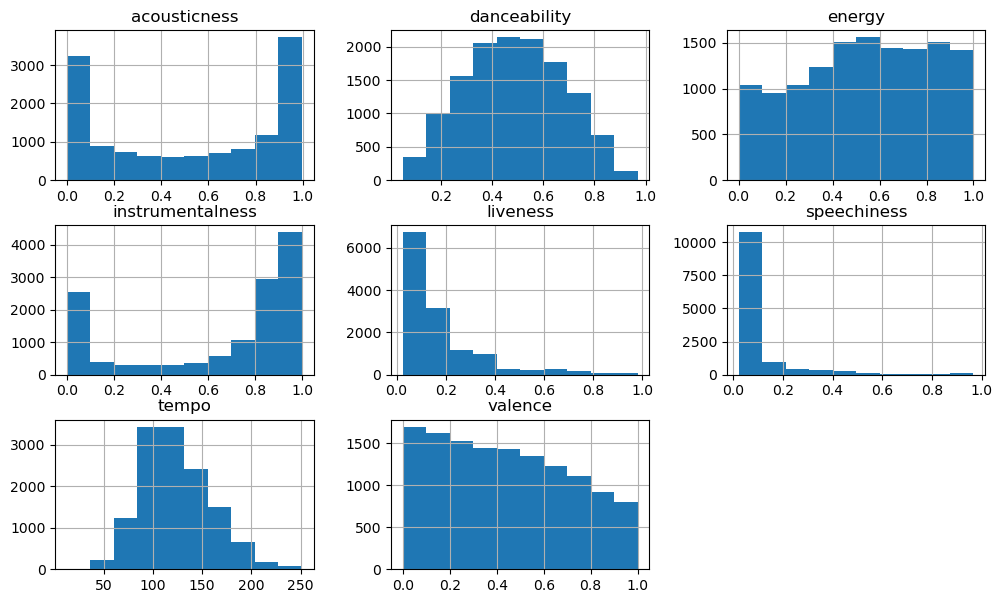

In [17]:
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
tracks_labeled[audio_features].hist(figsize=(12,7))